In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import pickle
import tensorflow as tf

import IPython.display as ipd
import librosa
import librosa.display

from glob import glob
from dotenv import load_dotenv
from my_functions.my_fun import *
from sklearn.model_selection import train_test_split

In [2]:
load_dotenv()

AUDIO_DIR = os.getenv('PMEMO_AUDIO')
META_DIR = os.getenv('PMEMO_META')
ASSETS_DIR = os.getenv('ASSETS_DIR')

aux_dir = META_DIR.split('.')[0]
META_DIR = f'{aux_dir}_total.csv'

ANOTATION_DIR = os.getenv('PMEMO_ANOTATIONS')
ANOTATION_DIR = os.path.join(ANOTATION_DIR,'static_annotations.csv')


In [3]:
if not os.path.exists(AUDIO_DIR):
    print('el directorio de audios no se encontró')

if not os.path.exists(ASSETS_DIR):
    print('el directorio de assets no existe')
    
if not os.path.exists(META_DIR):
    print('el archivo de metadatos no existe')

# Cargar audios y metadatos

# Información de los audios

In [4]:
pmemo_meta = pd.read_csv(META_DIR)
pmemo_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   musicId            767 non-null    int64  
 1   fileName           767 non-null    object 
 2   title              767 non-null    object 
 3   artist             767 non-null    object 
 4   album              760 non-null    object 
 5   duration           767 non-null    float64
 6   chorus_start_time  767 non-null    object 
 7   chorus_end_time    767 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 48.1+ KB


In [5]:
pmemo_meta.describe()

,musicId,duration
count,767.000000,767.000000
mean,493.770535,38.877562
std,285.958166,13.668968
min,1.000000,16.080000
25%,238.500000,29.110000
50%,495.000000,36.130000
75%,739.500000,46.130000
max,1000.000000,88.240000


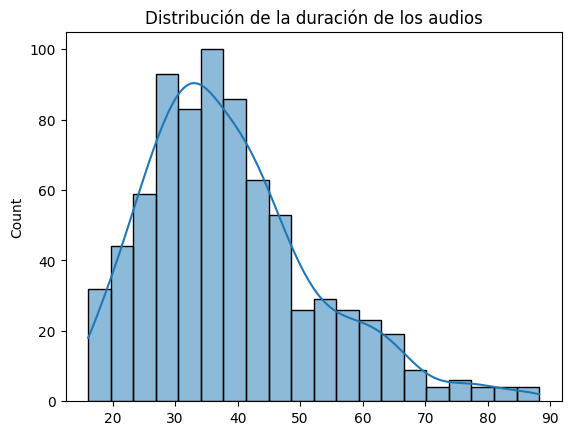

In [6]:
duracion = pmemo_meta['duration'].values

show_distribution(data=duracion,title='Distribución de la duración de los audios')

In [7]:
pmemo_meta.head()

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
0,1,1.mp3,Good Drank,2 Chainz,"Def Jam Presents: Direct Deposit, Vol. 2",32.10,02:35,03:05
1,4,4.mp3,X Bitch (feat. Future),21 Savage,Savage Mode,28.09,03:00,03:26
2,5,5.mp3,No Heart,21 Savage,Savage Mode,84.23,00:41,02:03
3,6,6.mp3,Red Opps,21 Savage,Red Opps,29.53,02:16,02:44
4,7,7.mp3,Girls Talk Boys,5 Seconds Of Summer,Ghostbusters (Original Motion Picture Soundtrack),29.11,02:30,02:57


## Cargar anotaciones

In [8]:
print(ANOTATION_DIR)
anot_df = pd.read_csv(ANOTATION_DIR)
anot_df.head(3)

E:\python_proy\mer\assets\PMEMO\PMEmo2019\annotations\static_annotations.csv


,musicId,Arousal(mean),Valence(mean)
0,1,0.4000,0.5750
1,4,0.2625,0.2875
2,5,0.1500,0.2000


## Cargar los audios

In [9]:
audio_list = pmemo_meta['fileName'].values
print(audio_list.shape)

audio_files = glob(f'{AUDIO_DIR}\\*.mp3')
print(len(audio_files))

(767,)
794


In [10]:
audio_files[0]
aux = audio_files[0].split('\\')[-1]
aux

'1.mp3'

In [11]:
i = 0
_audio_files = []
for audio_file in audio_files:
    aux = audio_file.split('\\')[-1]
    if aux in audio_list:
         i+=1
         _audio_files.append(audio_file)

audio_files = _audio_files
print(len(audio_files))
print(len(audio_list))
print(len(anot_df))

767
767
767


ordenar los archivos

In [12]:
#sorted_indices = np.argsort([int(os.path.basename(x).split('.')[0]) for x in file_paths])
audio_files =  np.array(audio_files)
sorted_idx = np.argsort([int(os.path.basename(x).split('.')[0]) for x in audio_files])
audio_files = audio_files[sorted_idx]
rnd_idx = np.random.randint(len(audio_list))

print(audio_files[rnd_idx])
print(audio_list[rnd_idx])

E:\python_proy\mer\assets\PMEMO\PMEmo2019\chorus\607.mp3
607.mp3


In [13]:
pmemo_meta.loc[rnd_idx]

musicId                           607
fileName                      607.mp3
title                 I Know Somebody
artist                         Locash
album                I Love This Life
duration                        44.14
chorus_start_time               02:09
chorus_end_time                 02:51
Name: 473, dtype: object

In [14]:
anot_df.iloc[rnd_idx]

musicId          607.0000
Arousal(mean)      0.7125
Valence(mean)      0.6375
Name: 473, dtype: float64

## Ejemplo con una muestra aleatoria

In [15]:
aux_meta =pmemo_meta.loc[pmemo_meta['fileName'] == audio_list[rnd_idx]] 
display(aux_meta)

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
473,607,607.mp3,I Know Somebody,Locash,I Love This Life,44.14,02:09,02:51


In [16]:
ipd.Audio(audio_files[rnd_idx])

In [17]:
y,sr = librosa.load(audio_files[rnd_idx],offset=0,duration=38)
print(f'y:{y[:20]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y:[ 1.7280399e-11  3.1832315e-11  4.5474735e-13  3.4560799e-11
  1.4097168e-11  4.6838977e-11 -7.2304829e-11 -1.7280399e-11
  7.9126039e-11  4.6384230e-11  3.2741809e-11  2.5465852e-11
 -3.3651304e-11  3.4560799e-11 -2.8194336e-11  7.2759576e-12
  7.2759576e-12  1.8189894e-11 -2.1827873e-11  1.8189894e-11]
shape y: (837900,)
sr: 22050


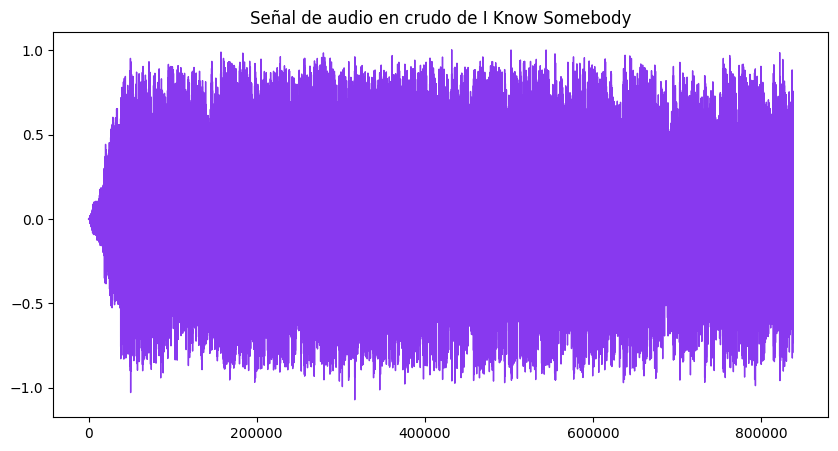

In [18]:
show_audio_signal(y,f"Señal de audio en crudo de {aux_meta['title'].values[0]}")

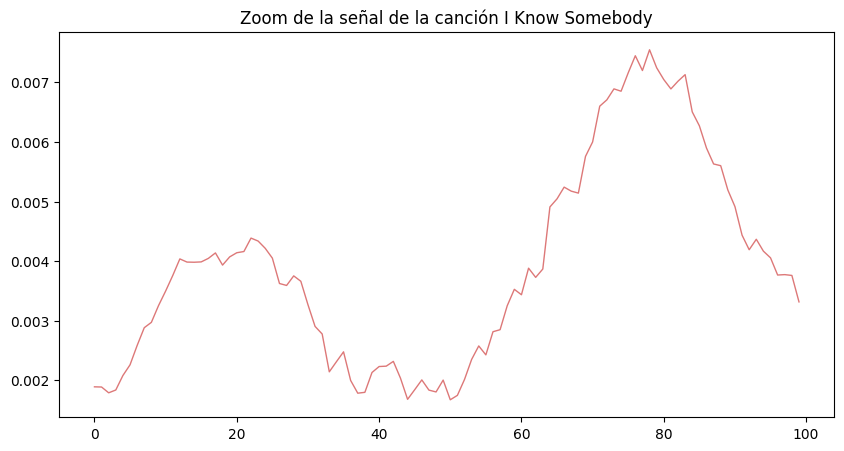

In [19]:
show_audio_signal(audio = pd.Series(y[1000:1100]),
                  title=f"Zoom de la señal de la canción {aux_meta['title'].values[0]}",
                  color='#dd7878')

### Chroma spectrogram

In [20]:
S = np.abs(librosa.stft(y))

chroma = librosa.feature.chroma_stft(S=S, sr=sr)
print(f'chroma: {chroma[:20]}')
print(f'shape chroma: {chroma.shape}')

chroma: [[0.85617316 0.46269062 0.30404752 ... 0.47309852 0.5760598  0.8659571 ]
 [0.8210144  0.47216424 0.41676617 ... 0.52782345 0.6947358  0.76246935]
 [0.8460405  0.6840173  0.6859372  ... 0.5663023  0.73136604 0.6403749 ]
 ...
 [0.96045905 0.5846441  0.3329831  ... 0.4818624  0.6473151  0.5888492 ]
 [1.         0.61134857 0.37521142 ... 0.4894406  0.6394747  0.6288676 ]
 [0.9129112  0.5022542  0.31104398 ... 0.43953693 0.5502979  0.6435302 ]]
shape chroma: (12, 1637)


In [21]:
crhoma_m = get_chromagram(audio=y,sr=sr) #Magnitud
print(f'chroma: {crhoma_m[:20]}')
print(f'shape chroma: {crhoma_m.shape}')

chroma: [[0.85617316 0.46269062 0.30404752 ... 0.47309852 0.5760598  0.8659571 ]
 [0.8210144  0.47216424 0.41676617 ... 0.52782345 0.6947358  0.76246935]
 [0.8460405  0.6840173  0.6859372  ... 0.5663023  0.73136604 0.6403749 ]
 ...
 [0.96045905 0.5846441  0.3329831  ... 0.4818624  0.6473151  0.5888492 ]
 [1.         0.61134857 0.37521142 ... 0.4894406  0.6394747  0.6288676 ]
 [0.9129112  0.5022542  0.31104398 ... 0.43953693 0.5502979  0.6435302 ]]
shape chroma: (12, 1637)


In [22]:
crhoma_p = get_chromagram(audio=y,sr=sr,power_spectrum=True,target_len=1637) #power
print(f'chroma: {crhoma_p[:20]}')
print(f'shape chroma: {crhoma_p.shape}')

chroma: [[0.88703036 0.26262364 0.11250774 ... 0.18095598 0.42687318 1.        ]
 [0.90938693 0.29472536 0.2607527  ... 0.24175522 0.6202294  0.79902047]
 [0.94524896 0.5029528  0.5753076  ... 0.23937984 0.6225969  0.4898972 ]
 ...
 [0.920239   0.33315653 0.05457208 ... 0.18137582 0.59321576 0.54444474]
 [0.90943295 0.29932147 0.06316316 ... 0.1756144  0.61006075 0.7101966 ]
 [0.87174666 0.27146348 0.07468352 ... 0.15035276 0.45287192 0.801375  ]]
shape chroma: (12, 1637)


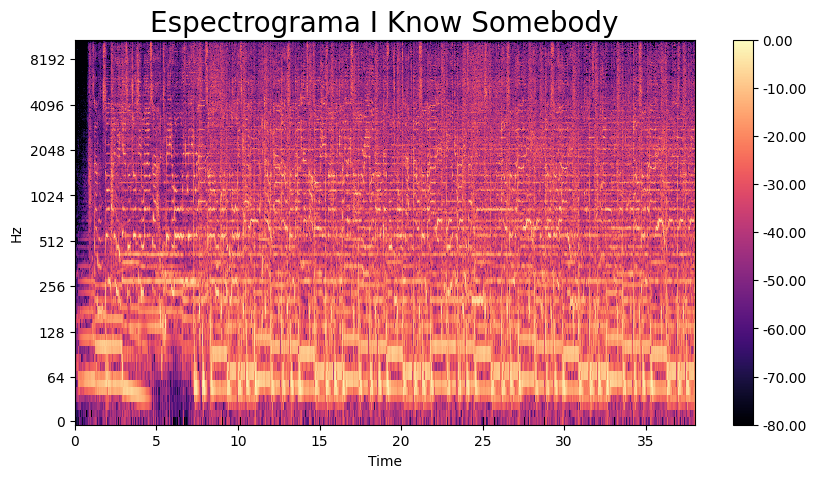

In [23]:
aux_Sp = get_spectrogram(audio=y)
show_spectrogram(aux_Sp,
                 title=f"Espectrograma {aux_meta['title'].values[0]}")

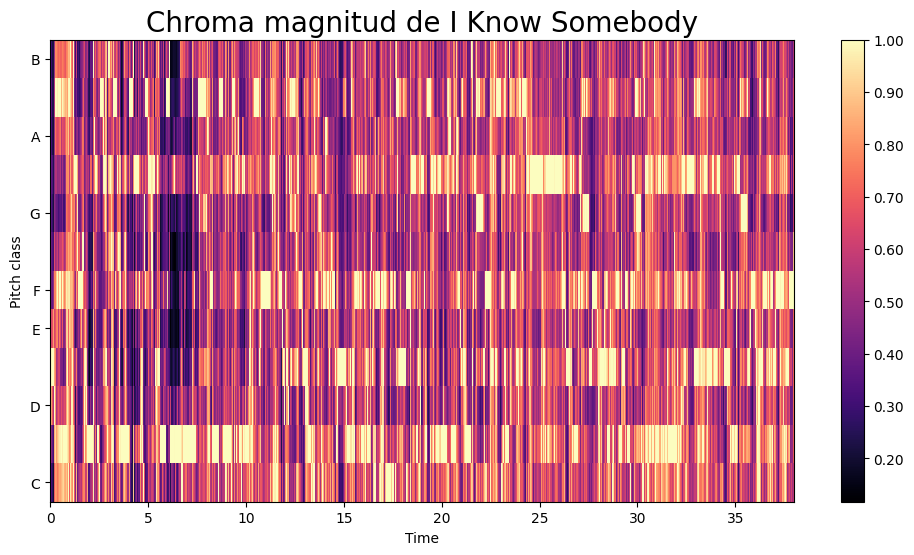

In [24]:
show_chromagram(chroma = crhoma_m,
                 title=f"Chroma magnitud de {aux_meta['title'].values[0]}")

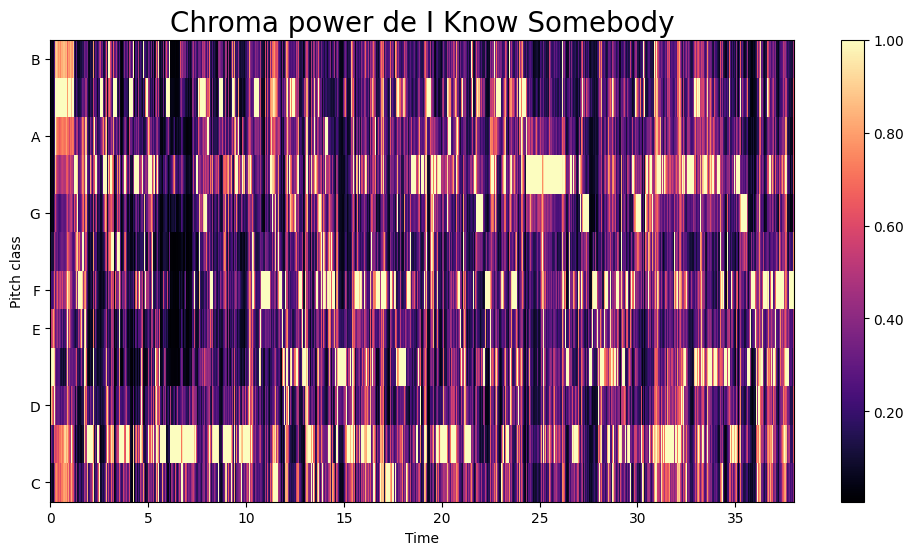

In [25]:
show_chromagram(chroma = crhoma_p,
                 title=f"Chroma power de {aux_meta['title'].values[0]}")

# Generar y guardar los chromas de todas las canciones

In [26]:
chromas_m = []
chromas_p = []

trunk = 1637

start_time = time.time()
for audio_file in audio_files:
    y,sr = librosa.load(audio_file,offset=0,duration=38)
    
    
    cp = get_chromagram(audio=y,sr=sr,power_spectrum=True,target_len = trunk)
    cm = get_chromagram(audio=y,sr=sr,target_len=trunk)
    
    chromas_p.append(cp) #power
    chromas_m.append(cm) #Magnitud
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Tiempo total transcurrido en la generación de chromas: {elapsed_time:.2f} segundos')

Tiempo total transcurrido en la generación de chromas: 132.25 segundos


In [27]:
chromas_m = np.array(chromas_m)
chromas_m.shape

(767, 12, 1637)

In [28]:
chromas_p = np.array(chromas_p)
chromas_p.shape

(767, 12, 1637)

In [29]:
b_chromas_m = chromas_m
b_chromas_p = chromas_p

# Un duro por la calle


In [30]:
print(f'chromas magintud shape: {chromas_m.shape}')

chromas_m = np.expand_dims(chromas_m,axis=-1)
chromas_m = np.repeat(chromas_m,3,axis=-1)

print(f'chromas magnitud expanded dim{chromas_m.shape}')
print(chromas_m[0].shape)

chromas magintud shape: (767, 12, 1637)
chromas magnitud expanded dim(767, 12, 1637, 3)
(12, 1637, 3)


In [31]:
print(f'chromas power shape: {chromas_p.shape}')

chromas_p = np.expand_dims(chromas_p,axis=-1)
chromas_p = np.repeat(chromas_p,3,axis=-1)

print(f'chromas power expanded dim{chromas_p.shape}')
print(chromas_p[0].shape)

chromas power shape: (767, 12, 1637)
chromas power expanded dim(767, 12, 1637, 3)
(12, 1637, 3)


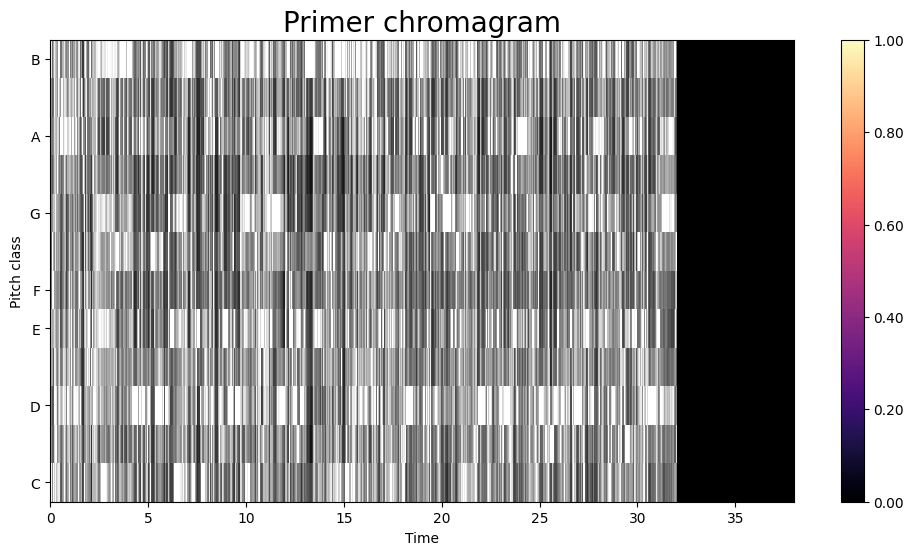

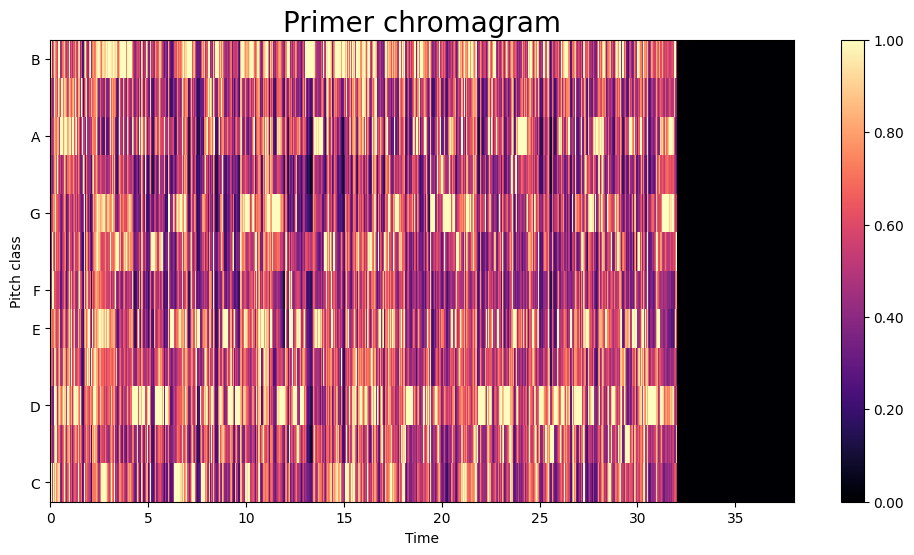

In [32]:
chromas_m[0].shape
show_chromagram(chromas_m[0],'Primer chromagram')
show_chromagram(b_chromas_m[0],'Primer chromagram')

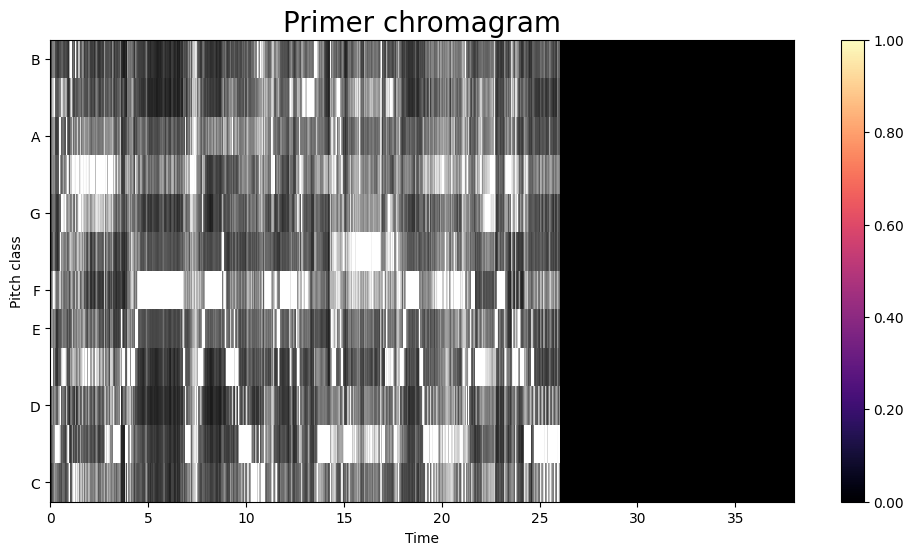

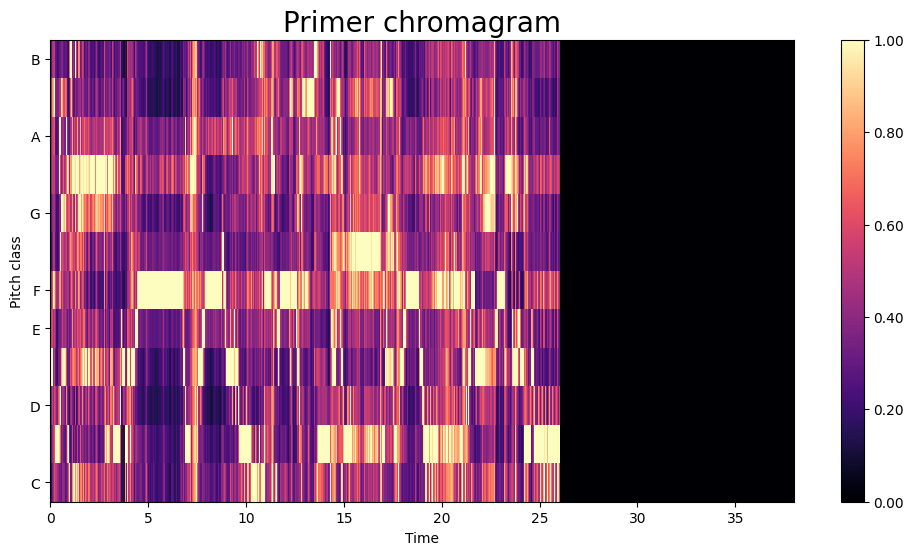

In [33]:
show_chromagram(chromas_m[10],'Primer chromagram')
show_chromagram(b_chromas_m[10],'Primer chromagram')


In [34]:
import cv2
start_time = time.time()
img = chromas_m[1]
img_resized = cv2.resize(img,(224,224))

end_time = time.time()
elapsed_time = end_time - start_time

print(img_resized.shape)
print(img_resized[10:20])

print(f'Tiempo transcurrido en el resize de una imagen: {elapsed_time}')


(224, 224, 3)
[[[0.520445   0.520445   0.520445  ]
  [0.6262048  0.6262048  0.6262048 ]
  [0.66919976 0.66919976 0.66919976]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.5478481  0.5478481  0.5478481 ]
  [0.64344597 0.64344597 0.64344597]
  [0.6787595  0.6787595  0.6787595 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.5752513  0.5752513  0.5752513 ]
  [0.6606871  0.6606871  0.6606871 ]
  [0.6883192  0.6883192  0.6883192 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.712267   0.712267   0.712267  ]
  [0.74689287 0.74689287 0.74689287]
  [0.7361178  0.7361178  0.7361178 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.73967016 0.73967016 0.73967016]
  [0.764134   0.764134 

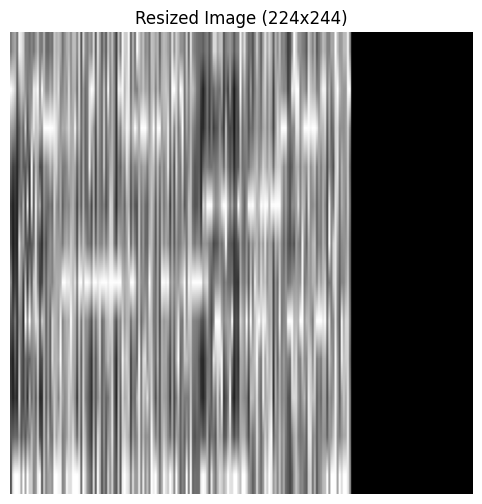

In [35]:
fig,ax = plt.subplots(figsize=(12,6))
# Display the resized image on the right subplot

ax.imshow( cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) )

ax.set_title('Resized Image (224x244)')

ax.axis('off')

plt.show()

In [36]:
import cv2
start_time = time.time()
img = chromas_m[29]
img_resized = cv2.resize(img,(224,224))

end_time = time.time()
elapsed_time = end_time - start_time

print(img_resized.shape)
print(img_resized[10:20])

print(f'Tiempo transcurrido en el resize de una imagen: {elapsed_time}')


(224, 224, 3)
[[[0.94287074 0.94287074 0.94287074]
  [0.97438717 0.97438717 0.97438717]
  [0.95792496 0.95792496 0.95792496]
  ...
  [0.48304027 0.48304027 0.48304027]
  [0.5047666  0.5047666  0.5047666 ]
  [0.86934674 0.86934674 0.86934674]]

 [[0.9403546  0.9403546  0.9403546 ]
  [0.9524333  0.9524333  0.9524333 ]
  [0.9218607  0.9218607  0.9218607 ]
  ...
  [0.4823597  0.4823597  0.4823597 ]
  [0.50855744 0.50855744 0.50855744]
  [0.86105007 0.86105007 0.86105007]]

 [[0.9378384  0.9378384  0.9378384 ]
  [0.93047947 0.93047947 0.93047947]
  [0.8857964  0.8857964  0.8857964 ]
  ...
  [0.48167914 0.48167914 0.48167914]
  [0.5123483  0.5123483  0.5123483 ]
  [0.85275334 0.85275334 0.85275334]]

 ...

 [[0.92525756 0.92525756 0.92525756]
  [0.8207101  0.8207101  0.8207101 ]
  [0.705475   0.705475   0.705475  ]
  ...
  [0.4782763  0.4782763  0.4782763 ]
  [0.53130245 0.53130245 0.53130245]
  [0.8112698  0.8112698  0.8112698 ]]

 [[0.9227414  0.9227414  0.9227414 ]
  [0.79875624 0.7987562

In [37]:
start_time = time.time()
res_crhomas_m = resize_spectrogramas(chromas_m,(224,244))

end_time = time.time()
elapsed_time = end_time - start_time

print(f'El redimensionamiento de los espectrogramas demoró: {elapsed_time}')

print(res_crhomas_m.shape)

El redimensionamiento de los espectrogramas demoró: 0.25005292892456055
(767, 244, 224, 3)


In [38]:
start_time = time.time()
res_crhomas_p = resize_spectrogramas(chromas_p,(224,244))

end_time = time.time()
elapsed_time = end_time - start_time

print(f'El redimensionamiento de los espectrogramas demoró: {elapsed_time}')

print(res_crhomas_p.shape)

El redimensionamiento de los espectrogramas demoró: 0.2510347366333008
(767, 244, 224, 3)


In [40]:
save_spectrograms(res_crhomas_m,'chromas_magnitud','')
save_spectrograms(res_crhomas_p,'chromas_power','')

Espectrogramas guardados exitosamente
Espectrogramas guardados exitosamente


'chromas_power.pkl'